In [1]:
import pandas as pd
# %env PYTORCH_ENABLE_MPS_FALLBACK=1
%load_ext autoreload
%autoreload

from bins import Bins
from eventsreader import Frame
from hist_utils import HistMaker, HistMaker1d, geom_avg1d, symmetrize
from hist_template import set_opt_text, set_th1, set_pad
import helicity_model_1d
import helicity_model_3d
from plotting import plot_losses, show_results, paveTexts, show_mass_z
from ROOT import TH1, TF1, TCanvas, gStyle, TLegend
import calendar, os
from time import gmtime

Welcome to JupyROOT 6.28/04


In [2]:
#!pip install openpyxl

In [3]:
gStyle.SetOptStat(0)

analyse_3d = True
learn_norm = False
same_sign_symm = True
ag1580ag = True
event_mixing = False
symmetrize_explicit = False
read_saved = False
range_used = range(0,12)
fraction = 0.8
frame = Frame.HX

DIR_NAME = f"results_{'ag1580ag' if ag1580ag else 'ag1230ag'}_{'3d' if analyse_3d else '1d'}_{'symm' if symmetrize_explicit else 'nosymm'}_{frame.name}{'_mix' if event_mixing else ''}"
if not os.path.isdir(DIR_NAME):
    os.mkdir(DIR_NAME)

In [4]:
import torch

torch.device("mps")
torch.manual_seed(0)

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)

from tqdm.notebook import tqdm

import warnings

In [5]:
TH1.SetDefaultSumw2()

In [6]:
from hist_utils import CombinedHistMaker

if ag1580ag:
    ekin = 1580
    filename_data_np = "063_088_ag158ag_3200A_accepted_np.dat"
   # filename_data_np = "mar19_diele_inmedium_helip1cm_ag1580ag_np.dat"
   # filename_data_np = "mar19_diele_inmedium_helip1cm_ag1580ag_jver22_np.dat"
    filename_data_pp = "063_088_ag158ag_3200A_accepted_pp.dat"
    filename_data_nn = "063_088_ag158ag_3200A_accepted_nn.dat"
    filename_data_np_mix = "063_088_ag158ag_3200A_accepted_np_mix_hc.dat"
    filename_data_pp_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_pp_mix_hc.dat"
    filename_data_nn_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_nn_mix_hc.dat"
    filename_MC_rho_4pi_heli0 = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_2_np_kine.dat"
    filename_MC_rho_4pi_heli1 = "mar19_diele_inmedium_helip1cm_ag1580ag_jver22_2_np_kine.dat"
   # filename_MC_rho_heli0_np = "mar19_diele_inmedium_heli0cm_ag1580ag_np.dat"
   # filename_MC_rho_heli0_np = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_np.dat"
   # filename_MC_rho_heli0_pp = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_pp.dat"
   # filename_MC_rho_heli0_nn = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_nn.dat"
    filename_MC_rho_heli0_np = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_np_newCuts.dat"
    filename_MC_rho_heli0_pp = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_pp_newCuts.dat"
    filename_MC_rho_heli0_nn = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_nn_newCuts.dat"
    filename_MC_rho_heli1 = "mar19_diele_inmedium_helip1cm_ag1580ag_jver22_np.dat"
    filename_MC_pi0 = "mar19_diele_pi0_heli0cm_ag1580ag_jver22_np.dat"
    filename_MC_mix = "mar19_diele_pi0_heli0cm_ag1580ag_np_mix.dat"
    if same_sign_symm:
        filename_data_pp = "063_088_ag158ag_3200A_accepted_pp_symm.dat"
        filename_data_nn = "063_088_ag158ag_3200A_accepted_nn_symm.dat"
       # filename_data_pp_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_pp_mix_hc_symm.dat"
       # filename_data_nn_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_nn_mix_hc_symm.dat"
       # filename_MC_rho_heli0_pp = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_pp_swapRandomly.dat"
       # filename_MC_rho_heli0_nn = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_nn_swapRandomly.dat"
else:
    ekin = 1230
    filename_data_np = "apr12_diele_088_090_ag123ag_2500A_accepted_np_2.dat"
    filename_data_pp = "088_090_ag123ag_2500A_accepted_pp.dat"
    filename_data_nn = "088_090_ag123ag_2500A_accepted_nn.dat"
    filename_data_np_mix = "apr12_diele_089_ag123ag_2500A_accepted_93_np_mix_hc.dat"
    filename_data_pp_mix = "088_090_ag123ag_2500A_accepted_pp_mix_hc.dat"
    filename_data_nn_mix = "088_090_ag123ag_2500A_accepted_nn_mix_hc.dat"
    filename_MC_rho_heli0_np = "mar19_diele_inmedium_heli0cm_ag1230ag_jver22_np.dat"
    filename_MC_rho_heli0_pp = "mar19_diele_inmedium_heli0cm_ag1230ag_jver22_pp.dat"
    filename_MC_rho_heli0_nn = "mar19_diele_inmedium_heli0cm_ag1230ag_jver22_nn.dat"
    filename_MC_rho_heli1 = "mar19_diele_inmedium_helip1cm_ag1580ag_jver22_np.dat"
    filename_MC_pi0 = "mar19_diele_pi0_heli0cm_ag1580ag_np.dat"
    filename_MC_mix = "mar19_diele_pi0_heli0cm_np_mix.dat"

HistMakerClass = HistMaker if analyse_3d else HistMaker1d

bins = Bins.readFrom("ranges.yml")
#histMakerData_np = HistMakerClass("apr12_diele_088_090_ag123ag_2500A_accepted_np_mix_hc_sample_2.dat", "_data", bins, frame)
if event_mixing:
    histMakerData_np = HistMakerClass(filename_data_np_mix, "_data_np", bins, frame, ekin)
else:
    histMakerData_np = HistMakerClass(filename_data_np, "_data_np", bins, frame, ekin)
histsData_np = histMakerData_np.make_hists  ()
histMakerData_pp = HistMakerClass(filename_data_pp, "_data_pp", bins, frame, ekin)
histsData_pp = histMakerData_pp.make_hists()
histMakerData_nn = HistMakerClass(filename_data_nn, "_data_nn", bins, frame, ekin)
histsData_nn = histMakerData_nn.make_hists()

histMakerData_np_mix = HistMakerClass(filename_data_np_mix, "_data_np_mix", bins, frame, ekin)
histsData_np_mix = histMakerData_np_mix.make_hists()
histMakerData_pp_mix = HistMakerClass(filename_data_np_mix, "_data_pp_mix", bins, frame, ekin)
histsData_pp_mix = histMakerData_pp_mix.make_hists()
histMakerData_nn_mix = HistMakerClass(filename_data_nn_mix, "_data_nn_mix", bins, frame, ekin)
histsData_nn_mix = histMakerData_nn_mix.make_hists()

histMakerMC_rho_heli0_np = HistMakerClass(filename_MC_rho_heli0_np, "_MC_rho_heli0", bins, frame, ekin)
histMakerMC_rho_heli0_pp = HistMakerClass(filename_MC_rho_heli0_pp, "_MC_rho_heli0_pp", bins, frame, ekin)
histMakerMC_rho_heli0_nn = HistMakerClass(filename_MC_rho_heli0_nn, "_MC_rho_heli0_nn", bins, frame, ekin)
histMakerMC_rho_heli1 = HistMakerClass(filename_MC_rho_heli1, "_MC_rho_heli1", bins, frame, ekin)
histMakerMC_pi0 = HistMakerClass(filename_MC_pi0, "_MC_pi0", bins, frame, ekin)
histMakerMC_mix = HistMakerClass(filename_MC_mix, "_MC_mix", bins, frame, ekin)
#histMakerMC_mix = HistMakerClass("test_inmedium_heli0cm_np_mix.dat", "_MC_rho_mix", bins, frame)
#histMakerMC_mix = HistMakerClass("mar19_diele_pi0_heli0cm_np_mix.dat", "_MC_rho_mix", bins, frame)
def get_hist_maker_mc(sign, hist_index):
    if event_mixing:
        return histMakerMC_mix
    else:
        if hist_index < 3:
            return CombinedHistMaker(histMakerMC_pi0, histMakerMC_rho_heli0_np, fraction)
        else:
            if sign == "np":
                return histMakerMC_rho_heli0_np
            elif sign == "pp":
                return histMakerMC_rho_heli0_pp
            else:
                return histMakerMC_rho_heli0_nn
        # return histMakerMC_rho_heli0_np

Pickle file exists
[01/16/2024, 15:26:10]: iter  0
[01/16/2024, 15:26:10] Before processing events
Num events 411996
Num non-null events 411996
[01/16/2024, 15:26:12] After processing events
#1 result length 5
Pickle file exists
[01/16/2024, 15:26:12]: iter  1
[01/16/2024, 15:26:12] Before processing events
Num events 82572
Num non-null events 82572
[01/16/2024, 15:26:12] After processing events
#1 result length 5
Pickle file exists
[01/16/2024, 15:26:13]: iter  2
[01/16/2024, 15:26:13] Before processing events
Num events 134850
Num non-null events 134850
[01/16/2024, 15:26:13] After processing events
#1 result length 5
Pickle file exists
[01/16/2024, 15:26:19]: iter  3
[01/16/2024, 15:26:19] Before processing events
Num events 1146500
Num non-null events 1146500
[01/16/2024, 15:26:22] After processing events
#1 result length 5
Pickle file exists
[01/16/2024, 15:26:28]: iter  4
[01/16/2024, 15:26:28] Before processing events
Num events 1146500
Num non-null events 1146500
[01/16/2024, 1

In [7]:
torch.backends.mps.is_available()
#mps_device = torch.device("mps")
mps_device = torch.device("cpu")
bounds = torch.tensor([[-2, ],
                       [ 2, ]], dtype=torch.float)
bounds = bounds.to(mps_device)


xs = torch.linspace(bounds[0][0], bounds[1][0], 101)

In [8]:
parameters_all_np = []
losses_all_np = [[]]* len(range_used)

fit_simple = helicity_model_3d.fit_simple if analyse_3d else helicity_model_1d.fit_simple

for HIST_INDEX in range_used:
    simple_model = helicity_model_3d.Helicity3d(learn_norm) if analyse_3d else helicity_model_1d.Helicity1d(learn_norm)
    hist_data_simple = histsData_np[0][HIST_INDEX]
    hist_mc_simple = get_hist_maker_mc("np", HIST_INDEX).make_hists(0.0)[0][HIST_INDEX]
    if HIST_INDEX == 2:
        losses = fit_simple(simple_model, hist_data_simple, hist_mc_simple, 1000, 0.01, learn_norm)
    else:
        losses = fit_simple(simple_model, hist_data_simple, hist_mc_simple, 1000, 0.01, learn_norm)
    parameters_all_np.append([param for param in simple_model.parameters()])
    losses_all_np[HIST_INDEX] = losses
    
parameters_all_pp = []
losses_all_pp = [[]]* len(range_used)

for HIST_INDEX in range_used:
    simple_model = helicity_model_3d.Helicity3d(learn_norm) if analyse_3d else helicity_model_1d.Helicity1d(learn_norm)
    hist_data_simple = histsData_pp[0][HIST_INDEX]
    hist_mc_simple = get_hist_maker_mc("pp", HIST_INDEX).make_hists(0.0)[0][HIST_INDEX]
    losses = fit_simple(simple_model, hist_data_simple, hist_mc_simple, 10000, 0.01, learn_norm)
    parameters_all_pp.append([param for param in simple_model.parameters()])
    losses_all_pp[HIST_INDEX] = losses
    
parameters_all_nn = []
losses_all_nn = [[]]* len(range_used)

for HIST_INDEX in range_used:
    simple_model = helicity_model_3d.Helicity3d(learn_norm) if analyse_3d else helicity_model_1d.Helicity1d(learn_norm)
    hist_data_simple = histsData_nn[0][HIST_INDEX]
    hist_mc_simple = get_hist_maker_mc("nn", HIST_INDEX).make_hists(0.0)[0][HIST_INDEX]
    losses = fit_simple(simple_model, hist_data_simple, hist_mc_simple, 10000, 0.01, learn_norm)
    parameters_all_nn.append([param for param in simple_model.parameters()])
    losses_all_nn[HIST_INDEX] = losses

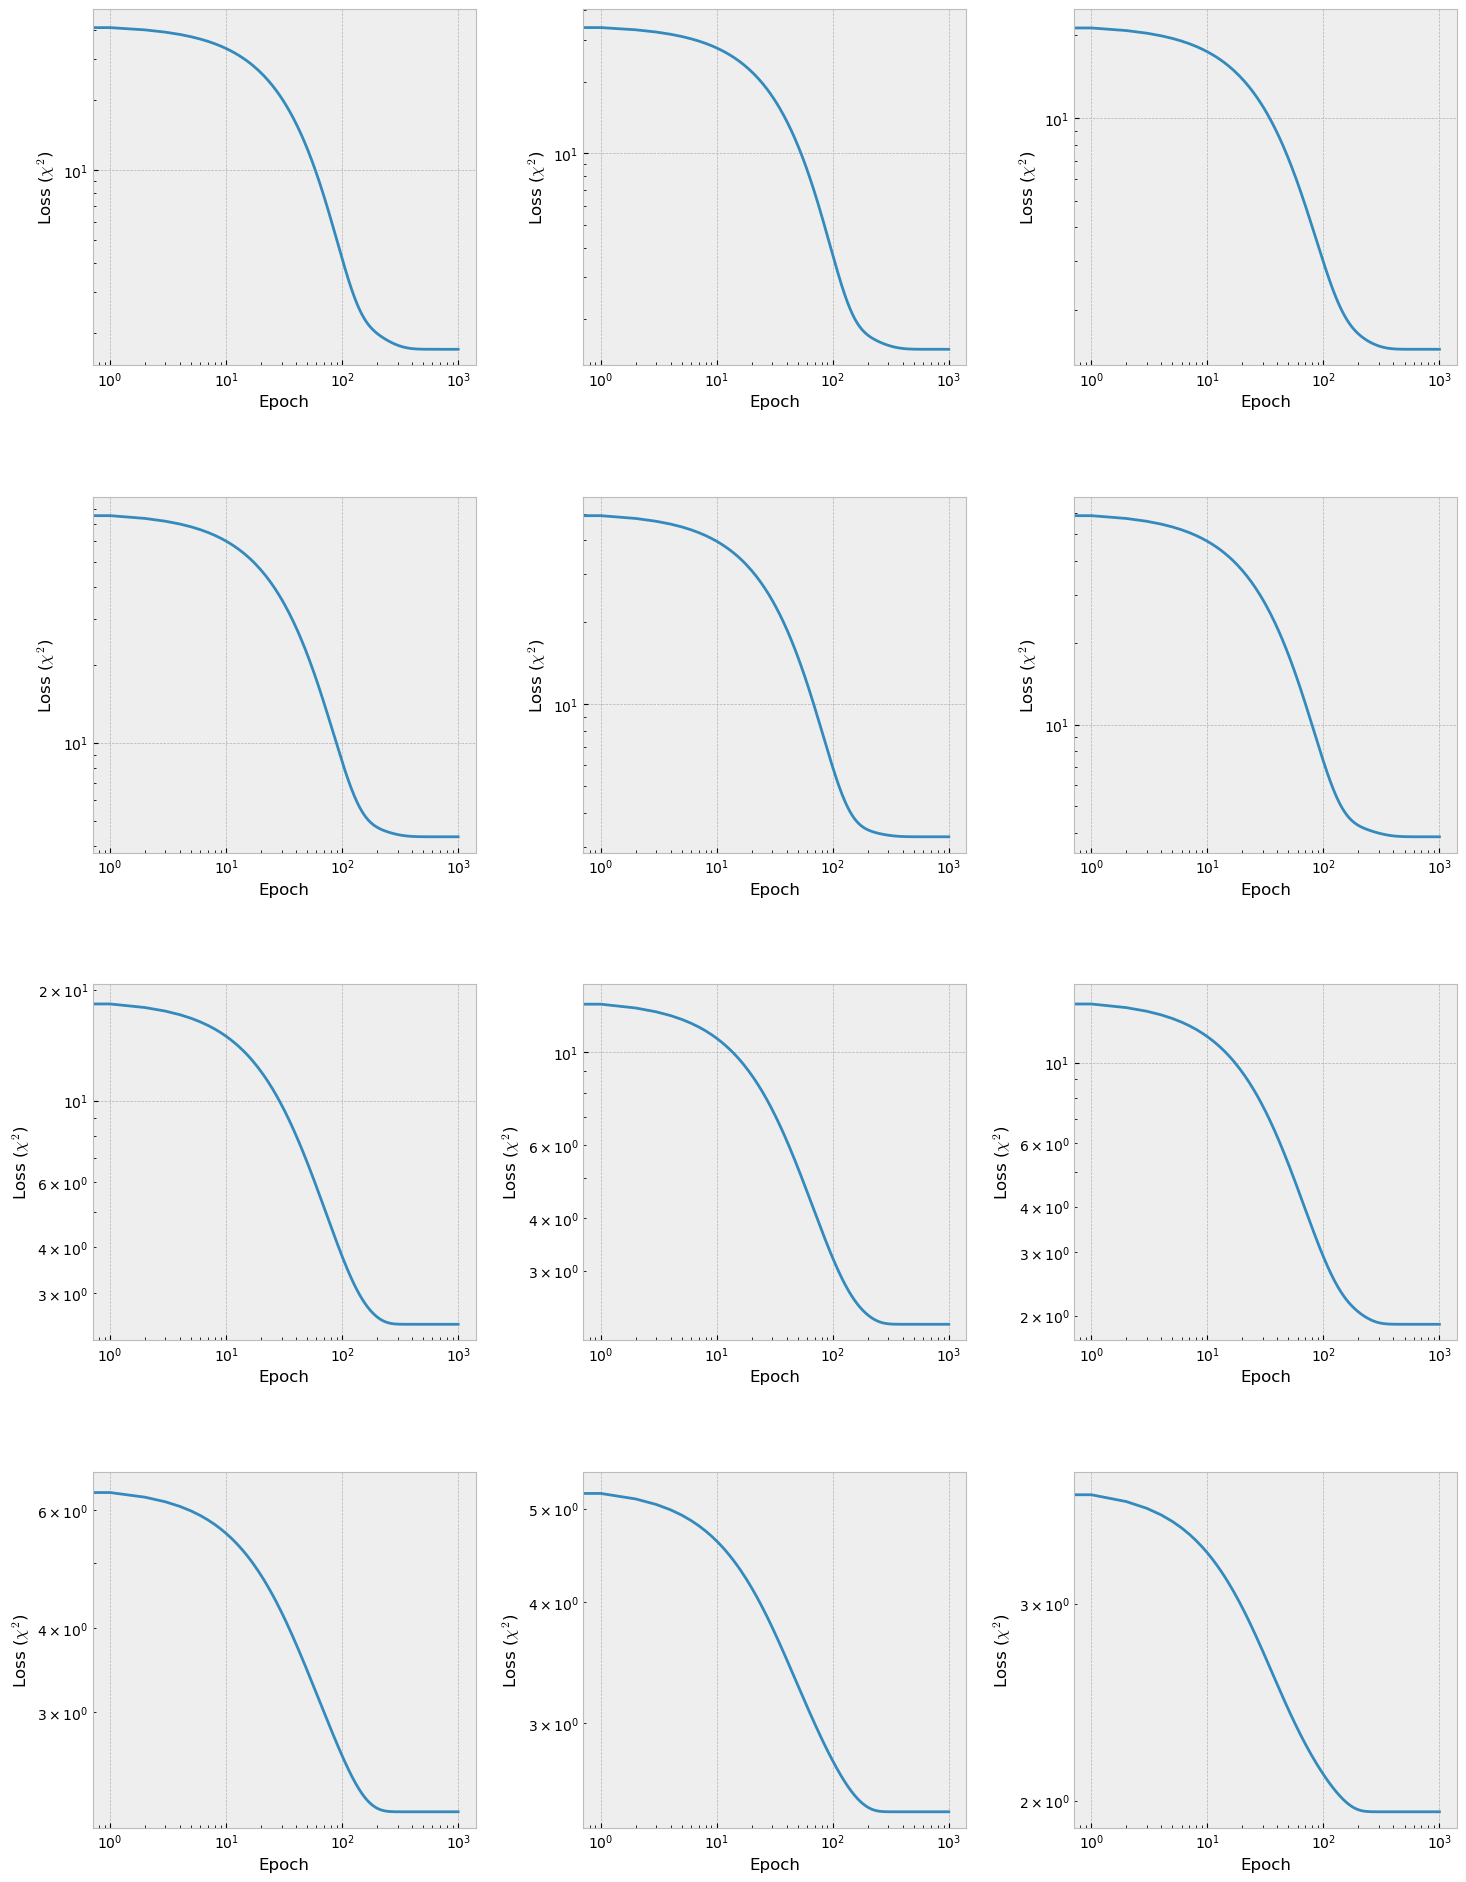

In [9]:
fig_np, ax_np = plot_losses(losses_all_np, range_used)

# Calculating covariance matrix for parameters

In general, if the value of the fitted model with $m$ parameters at point $x_i$ can be expressed as ({cite}`@cowan1998statistical`):
$$f(x_i,\mathbf{\lambda})=\sum_{j=1}^{m}a_j(x_i)\lambda_j\equiv\sum_{j=1}^{m}A_{ij}\lambda_j,$$
then the expression for $\chi^2$ is:
$$\chi^2=(\mathbf{y}-A\mathbf{\lambda})^T V^{-1}(\mathbf{y}-A\mathbf{\lambda}),$$
where $V$ is the covariance matrix of different data points. We have only statistical errors at each data point (histogram bin in our case), so we assume, witn $n$ data points (bins),
$$V^{-1}=\mathrm{diag}\left(\frac{1}{\sigma^2_{1}},\frac{1}{\sigma^2_{2}},\frac{1}{\sigma^2_{3}},...,\frac{1}{\sigma^2_{n}}\right).$$
The covariance matrix for for parameters, $U_{ij}=\mathrm{cov}[\hat{\lambda}_i,\hat{\lambda}_j]$ is calculated as
$$U=(A^TV^{-1}A)^{-1}.$$
In our case, the $i$-th row of matrix $A$, corresponding to the $i$-th data point (bin) has the following form:
$$\left(\frac{c_i}{I}\;\;\;\frac{c_i}{I}\cos^2(\theta_i)\;\;\;\frac{c_i}{I}\sin(2\theta_i)cos(\phi_i)\;\;\;\frac{c_i}{I}\sin^2(\theta_i)\cos(2\phi_i)\right),$$
where $\theta_i$, $\phi_i$ are values corresponding the bin center. Note, that one of the axes is $\cos(\theta)$, so $\arccos$ has to be calculated. $c_i$ is the bin content of the **unweighted** model histogram. $I$ is the integral of the model histogram **after applying the weights**. Thanks to that, the weighted histogram is always normalized to unity and can be compared to the experimental data histogram ($\mathbf{y}$) which is also normalized to unity all the time.

For the errors of the fit parameters, we just use square roots of the diagonal elements of the matrix $U$. However, with the matrix $A$ given above, we calculate the covariance matrix for the fit:
$$f(\theta,\phi)=A+B\cos^2(\theta_i)+C\sin(2\theta_i)cos(\phi_i)+D\sin^2(\theta_i)\cos(2\phi_i).$$
In order to get correct errors of the parameters of the fit:
$$f(\theta,\phi)\propto1+\lambda_\theta\cos^2(\theta_i)+\lambda_{\theta\phi}\sin(2\theta_i)cos(\phi_i)+\lambda_\phi\sin^2(\theta_i)\cos(2\phi_i),$$
we use error propagation to calculate the errors of ratios of ${B, C, D}$ parameters to $A$.

{bibliography}

Maybe covariance matrix:
tensor([[ 3.8894e-05, -2.0107e-04,  2.3754e-06,  5.0689e-06],
        [-2.0107e-04,  2.8519e-03,  1.5250e-04, -1.0692e-06],
        [ 2.3754e-06,  1.5250e-04,  2.2274e-04,  2.2191e-05],
        [ 5.0689e-06, -1.0692e-06,  2.2191e-05,  5.9704e-05]])
Compare:
Old: 0.117945195900259, new: 0.05344675949370441, new/old: 0.4531491010358909
Old: 0.042227912449889896, new: 0.014925916537009493, new/old: 0.3534609141458616
Old: 0.03631746290924082, new: 0.007727382046535726, new/old: 0.212773179278708
Maybe covariance matrix:
tensor([[ 4.6291e-05, -2.4592e-04,  8.2442e-07,  3.0153e-06],
        [-2.4592e-04,  3.4992e-03,  1.6671e-04, -2.5702e-05],
        [ 8.2442e-07,  1.6671e-04,  2.5741e-04,  1.4364e-05],
        [ 3.0153e-06, -2.5702e-05,  1.4364e-05,  6.5289e-05]])
Compare:
Old: 0.15459766038690834, new: 0.05926460101783997, new/old: 0.3833473344261465
Old: 0.05523601881826388, new: 0.01604861680641953, new/old: 0.2905462259910924
Old: 0.04690385239790407, new: 0.0

Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/can_cmp_0_np.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/can_cmp_0_np.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/comparison_2.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/can_cmp_0_np.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/can_cmp_3_np.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/can_cmp_3_np.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/comparison_5.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/can_cmp_3_np.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/can_cmp_6_np.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/can_cmp_6_np.gif has been created
Info in <T

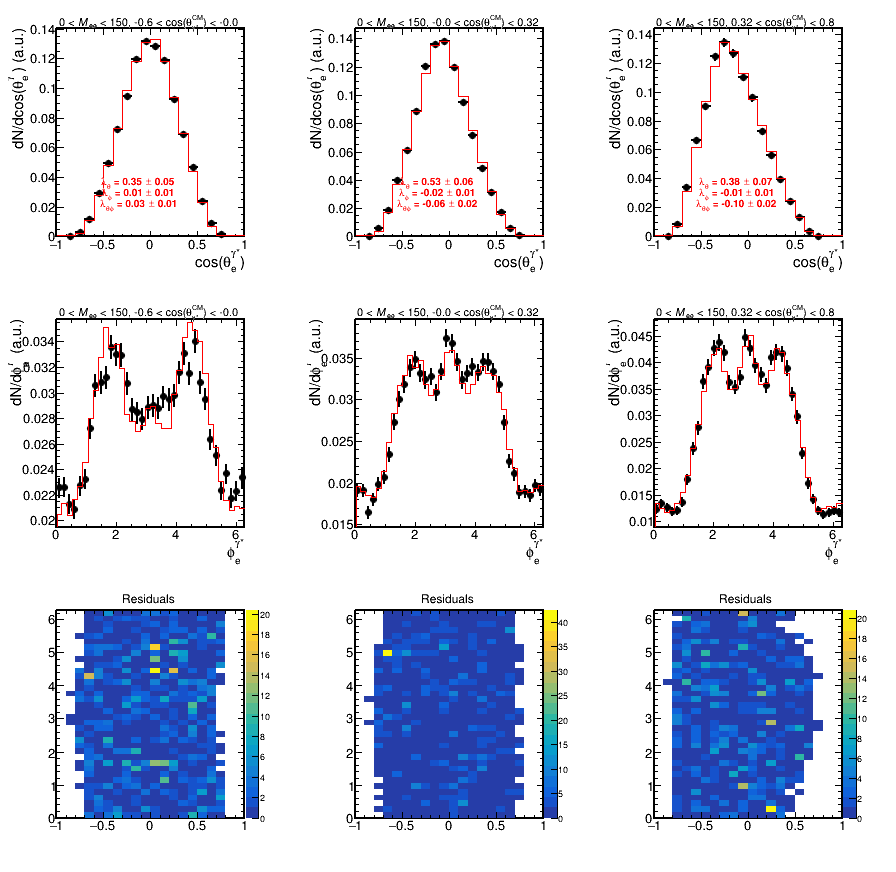

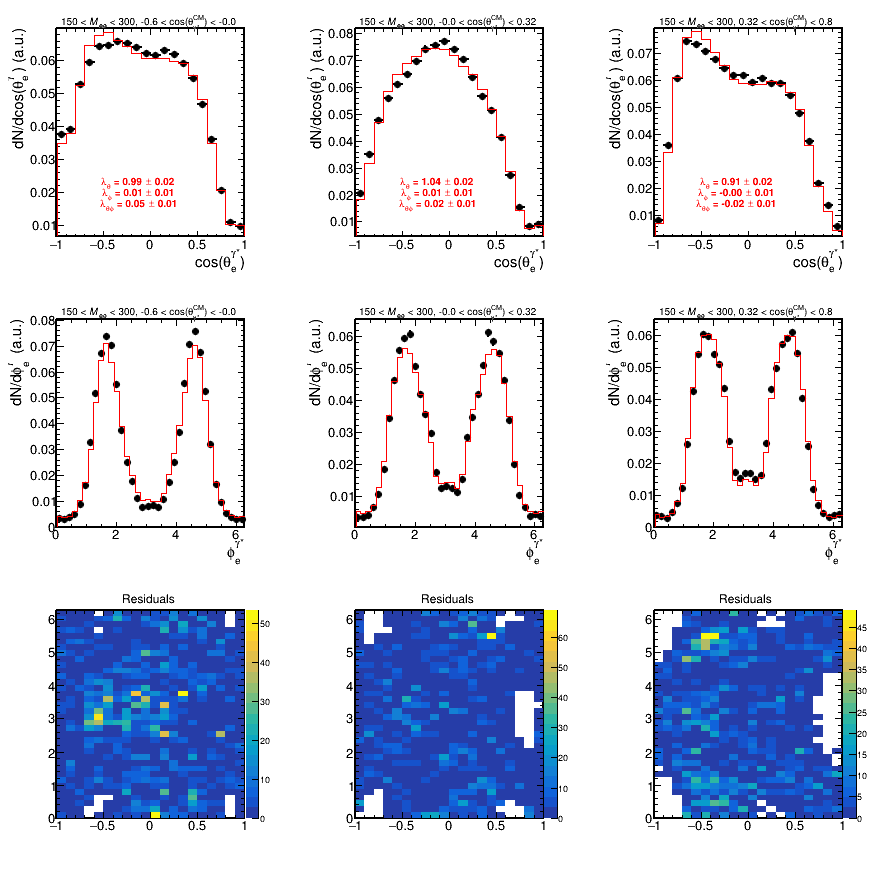

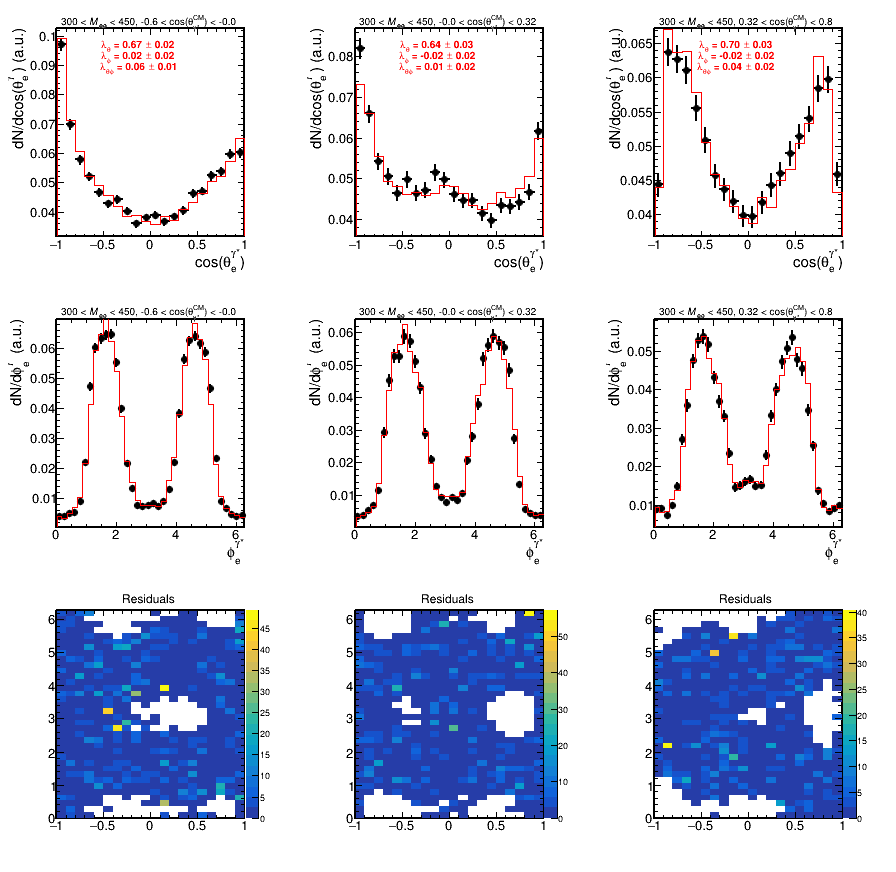

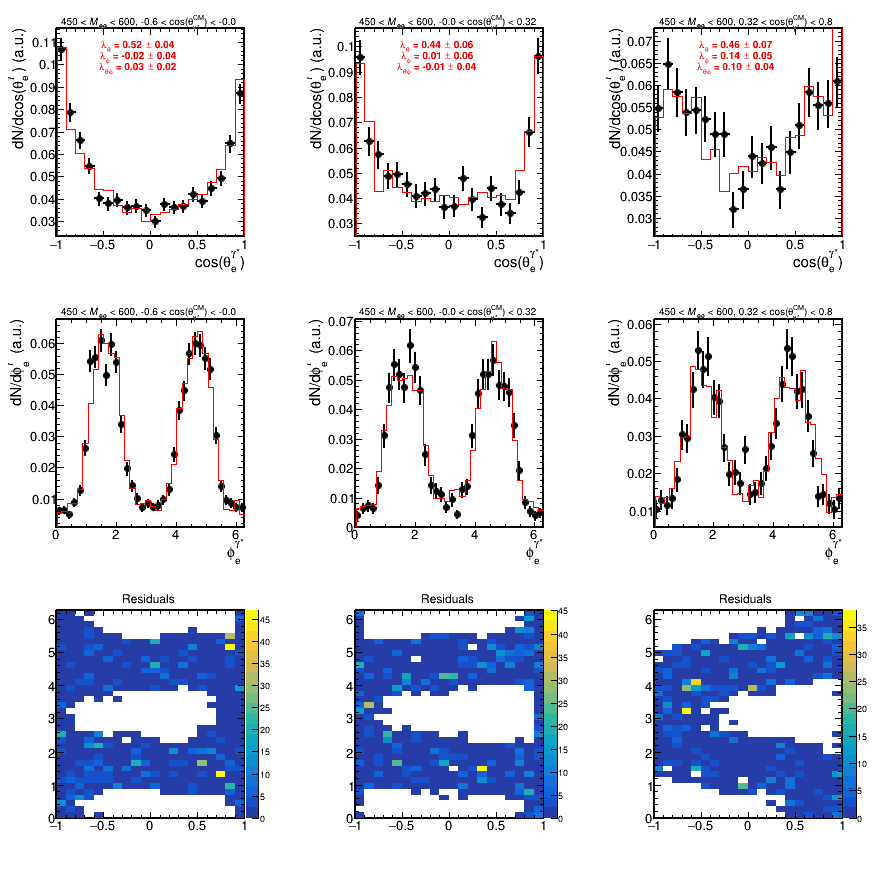

In [10]:
df_np = show_results("np", DIR_NAME, range_used, parameters_all_np, get_hist_maker_mc, bins, histsData_np, analyse_3d)

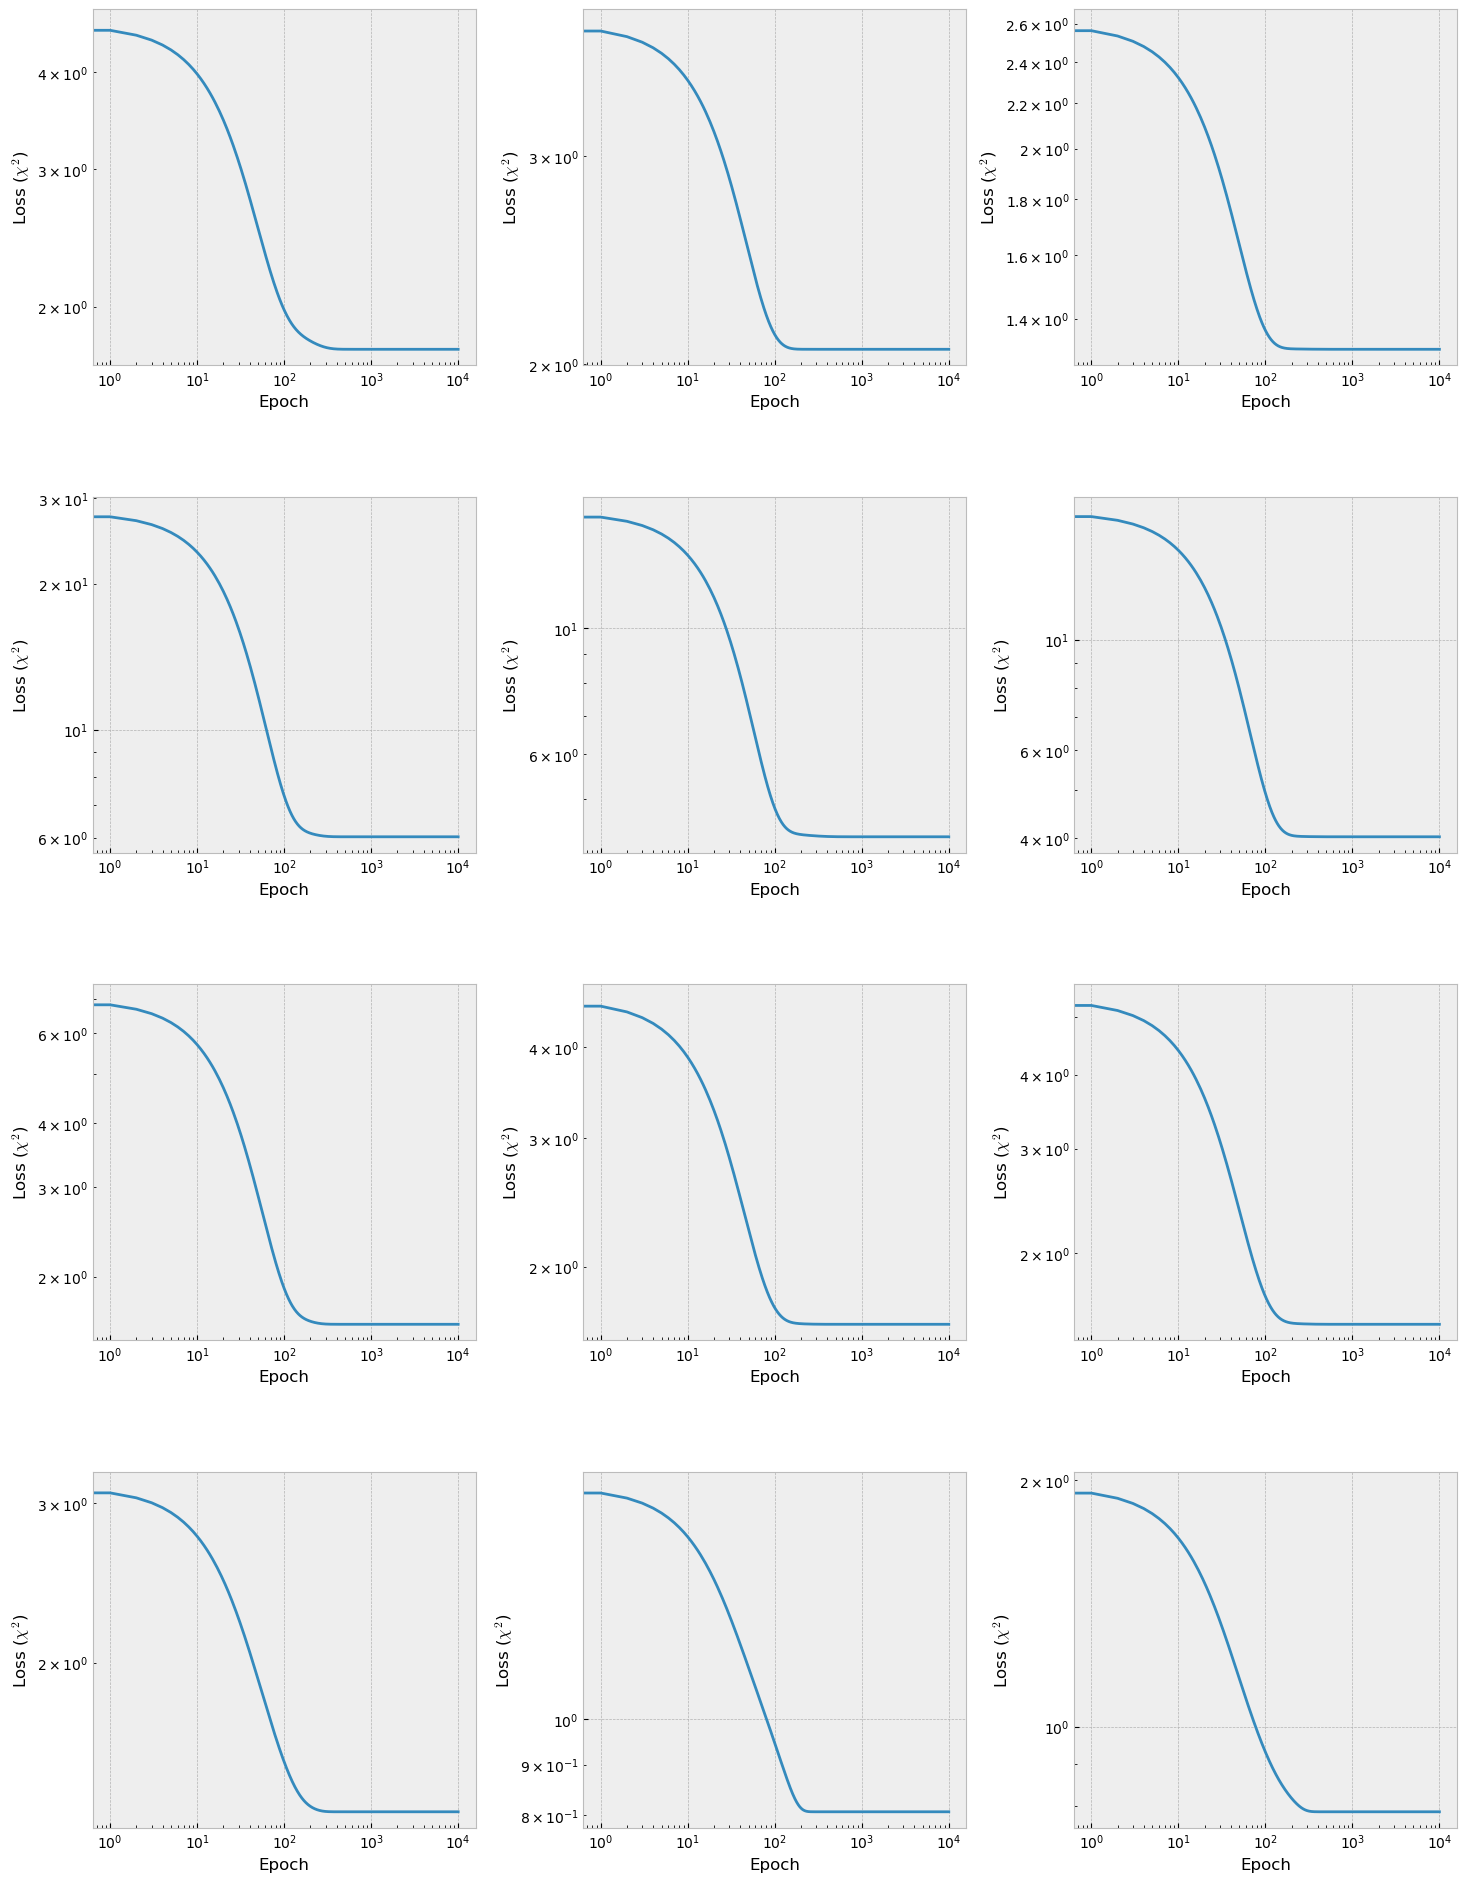

In [11]:
fig_pp, ax_pp = plot_losses(losses_all_pp, range_used)

Maybe covariance matrix:
tensor([[ 6.4177e-04, -3.8035e-03, -1.8633e-05, -9.6107e-06],
        [-3.8035e-03,  5.5464e-02,  3.7802e-03,  9.9704e-05],
        [-1.8633e-05,  3.7802e-03,  3.7818e-03,  3.7891e-04],
        [-9.6107e-06,  9.9704e-05,  3.7891e-04,  7.7325e-04]])
Compare:
Old: 0.9785666896135112, new: 0.23569078238913016, new/old: 0.24085306079876595
Old: 0.3395338506355164, new: 0.06154259492654838, new/old: 0.18125613929614715
Old: 0.22162820389482535, new: 0.027814206197910394, new/old: 0.12549939813215177
Maybe covariance matrix:
tensor([[ 8.4981e-04, -6.1084e-03,  9.0778e-05, -2.0298e-04],
        [-6.1084e-03,  1.1969e-01,  6.7507e-03,  3.6870e-04],
        [ 9.0778e-05,  6.7507e-03,  5.7774e-03,  4.9662e-04],
        [-2.0298e-04,  3.6870e-04,  4.9662e-04,  1.0308e-03]])
Compare:
Old: 0.43478225748850613, new: 0.3496964405986851, new/old: 0.8043024630735527
Old: 0.14860055657575502, new: 0.08080897369692164, new/old: 0.5437999396437392
Old: 0.08126868366318403, new: 0.

Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/can_cmp_0_pp.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/can_cmp_0_pp.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/comparison_2.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/can_cmp_0_pp.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/can_cmp_3_pp.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/can_cmp_3_pp.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/comparison_5.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/can_cmp_3_pp.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/can_cmp_6_pp.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/can_cmp_6_pp.gif has been created
Info in <T

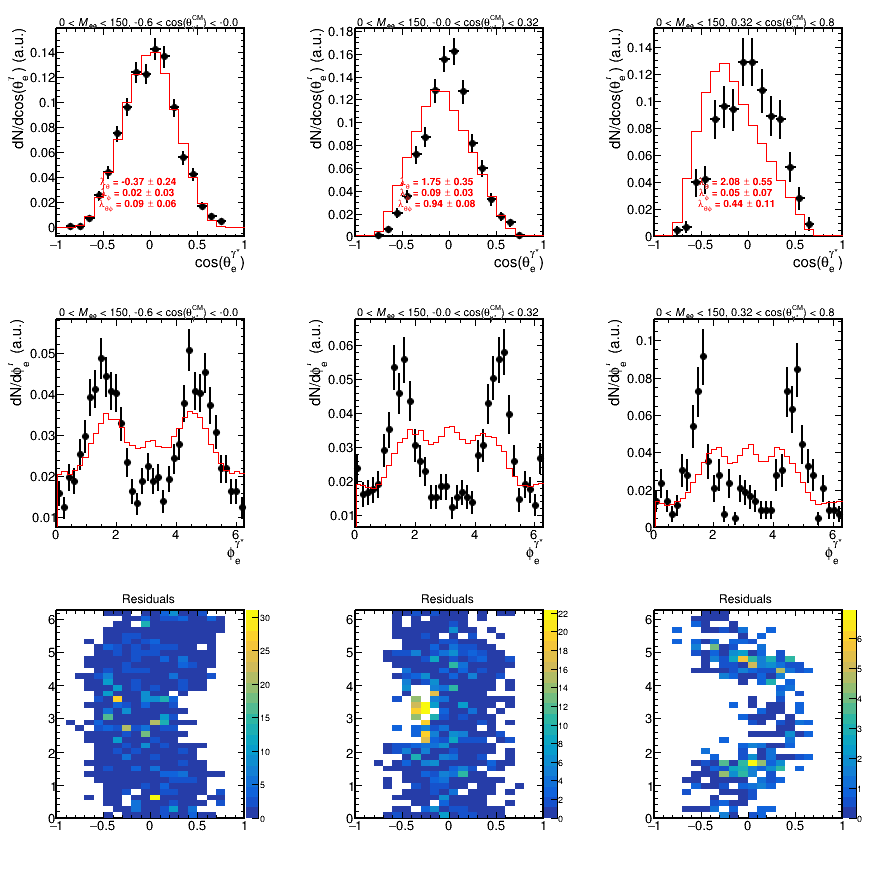

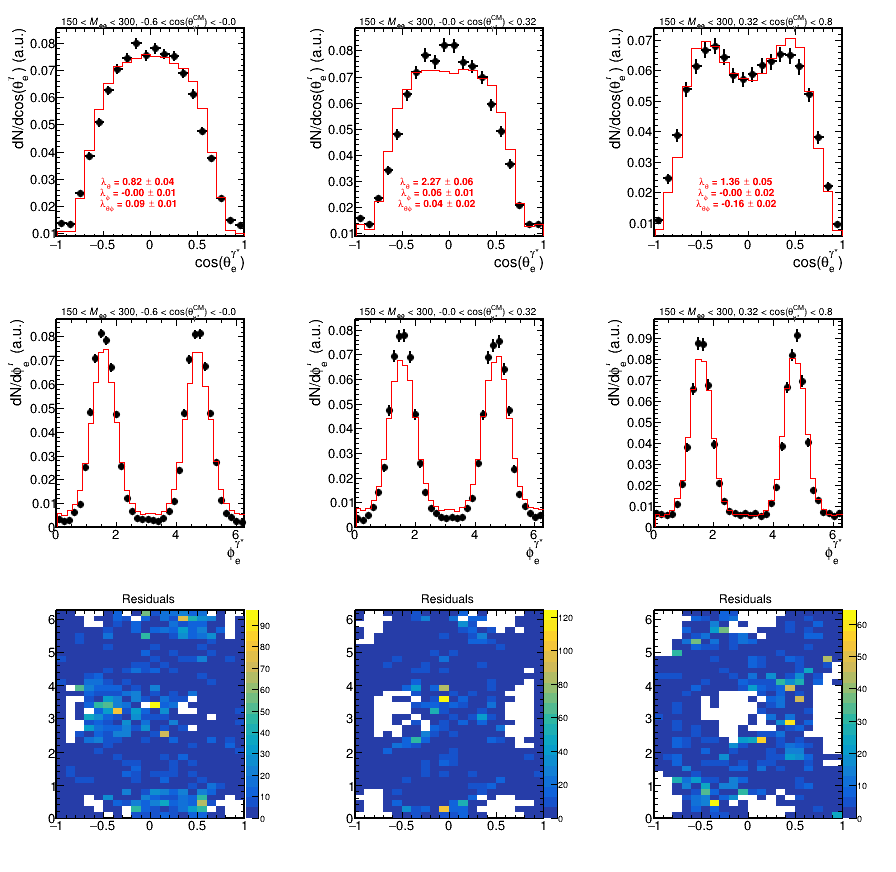

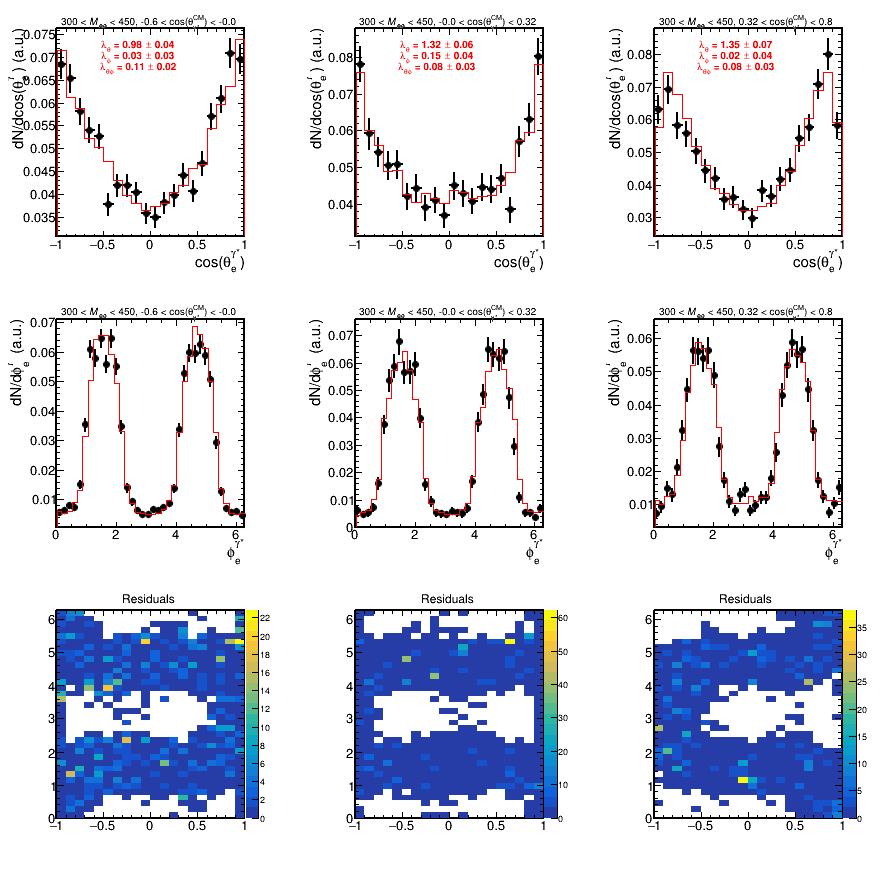

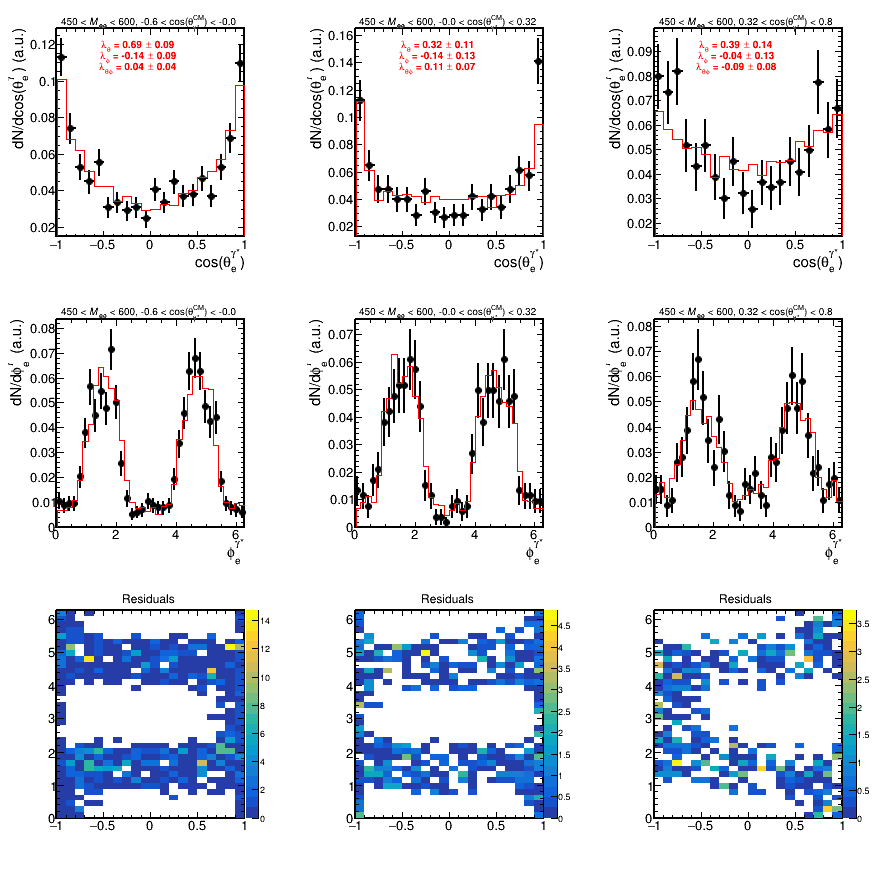

In [12]:
df_pp = show_results("pp", DIR_NAME, range_used, parameters_all_pp, get_hist_maker_mc, bins, histsData_pp, analyse_3d)

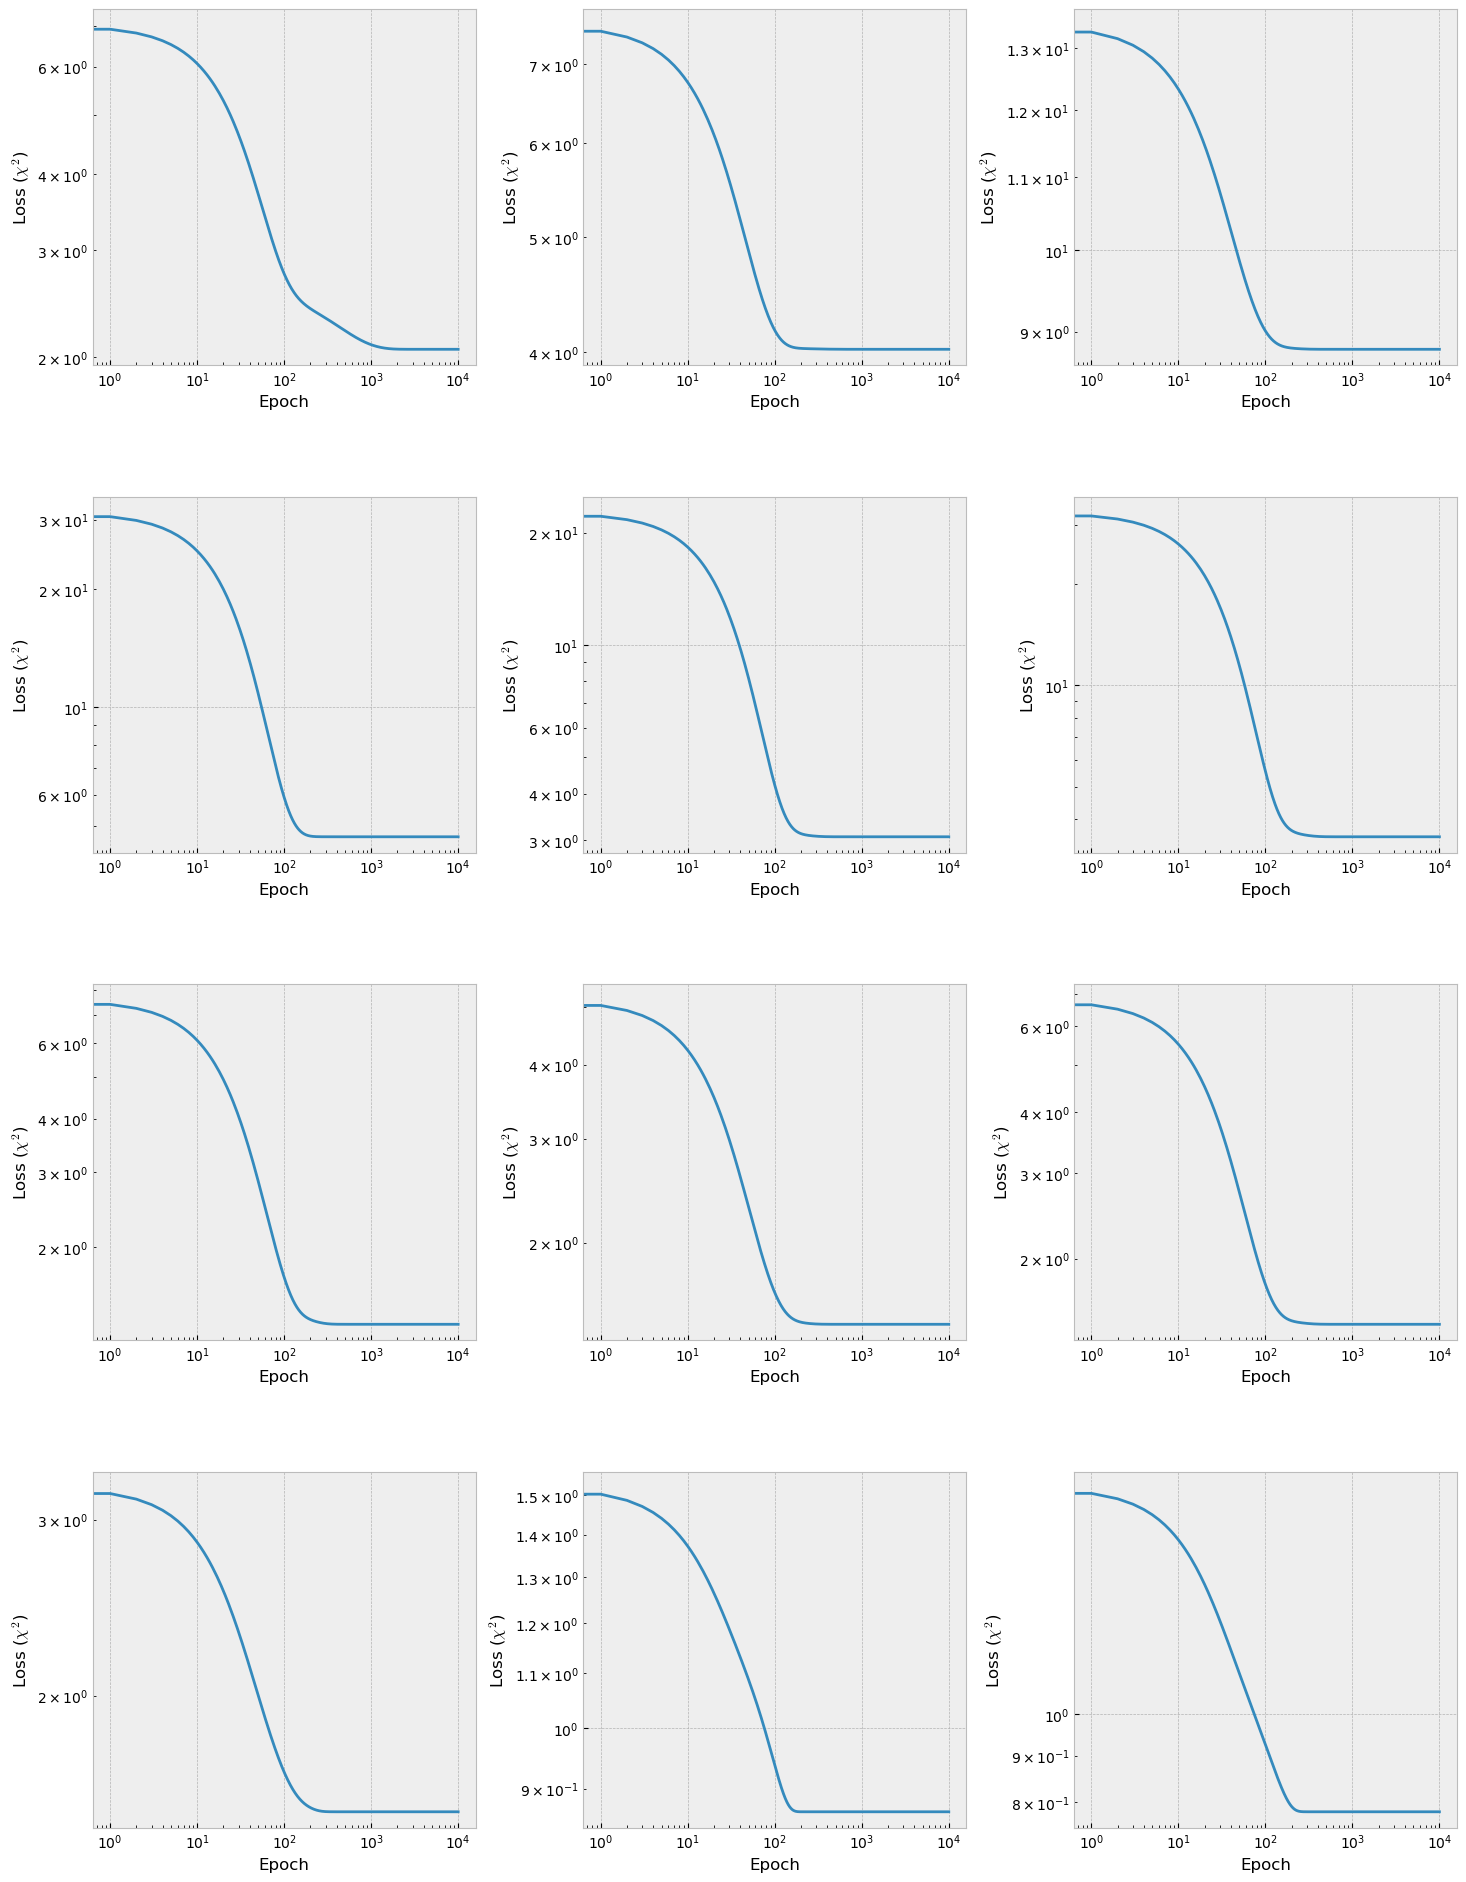

In [13]:
fig_nn, ax_nn = plot_losses(losses_all_nn, range_used)

Maybe covariance matrix:
tensor([[ 4.1442e-04, -2.9050e-03,  2.4533e-06, -3.5642e-05],
        [-2.9050e-03,  6.4073e-02,  2.9634e-03,  2.5325e-04],
        [ 2.4533e-06,  2.9634e-03,  3.7570e-03,  2.0048e-04],
        [-3.5642e-05,  2.5325e-04,  2.0048e-04,  5.6073e-04]])
Compare:
Old: 0.34830138788175335, new: 0.2913660625739611, new/old: 0.8365343139915321
Old: 0.06803792254627386, new: 0.06132044611861898, new/old: 0.9012686428941713
Old: 0.0475298256924094, new: 0.02370535752187035, new/old: 0.4987469904745756
Maybe covariance matrix:
tensor([[ 3.5344e-04, -2.1712e-03,  3.2807e-06, -6.8913e-05],
        [-2.1712e-03,  3.7900e-02,  2.6732e-03, -4.6749e-05],
        [ 3.2807e-06,  2.6732e-03,  2.2866e-03,  1.0637e-04],
        [-6.8913e-05, -4.6749e-05,  1.0637e-04,  3.9897e-04]])
Compare:
Old: 0.7818594171707715, new: 0.1991733230801707, new/old: 0.2547431401426324
Old: 0.25528229730925395, new: 0.04841072000970178, new/old: 0.18963602458910847
Old: 0.18535035459325597, new: 0.0199

Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/can_cmp_0_nn.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/can_cmp_0_nn.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/comparison_2.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/can_cmp_0_nn.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/can_cmp_3_nn.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/can_cmp_3_nn.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/comparison_5.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/can_cmp_3_nn.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/can_cmp_6_nn.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/can_cmp_6_nn.gif has been created
Info in <T

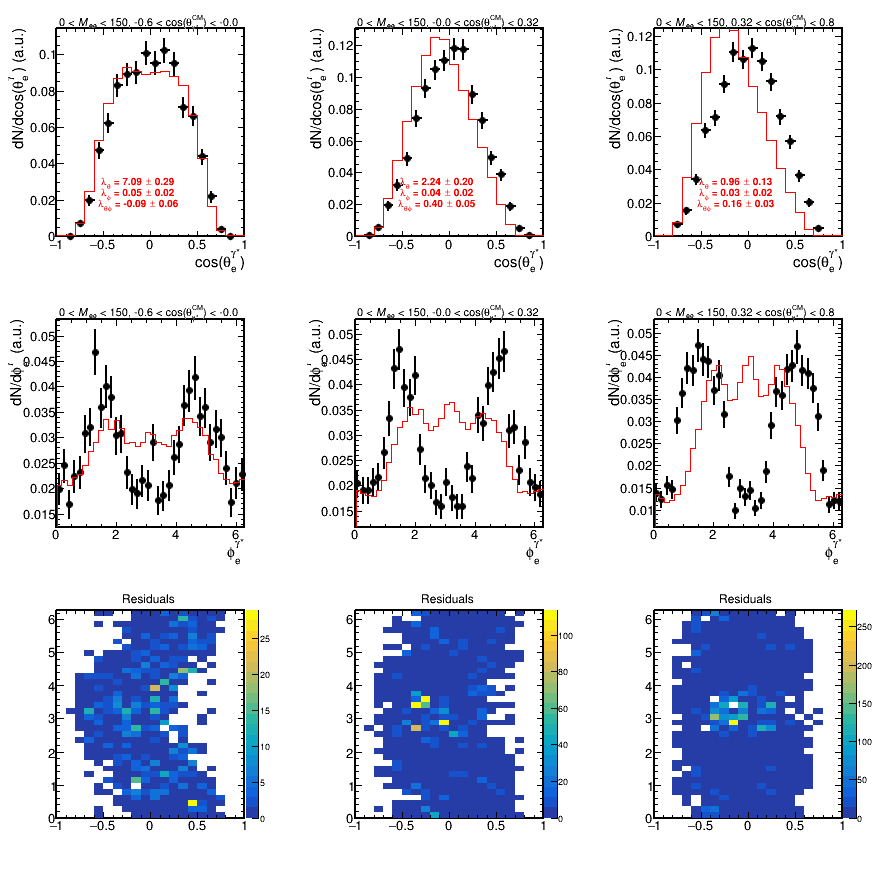

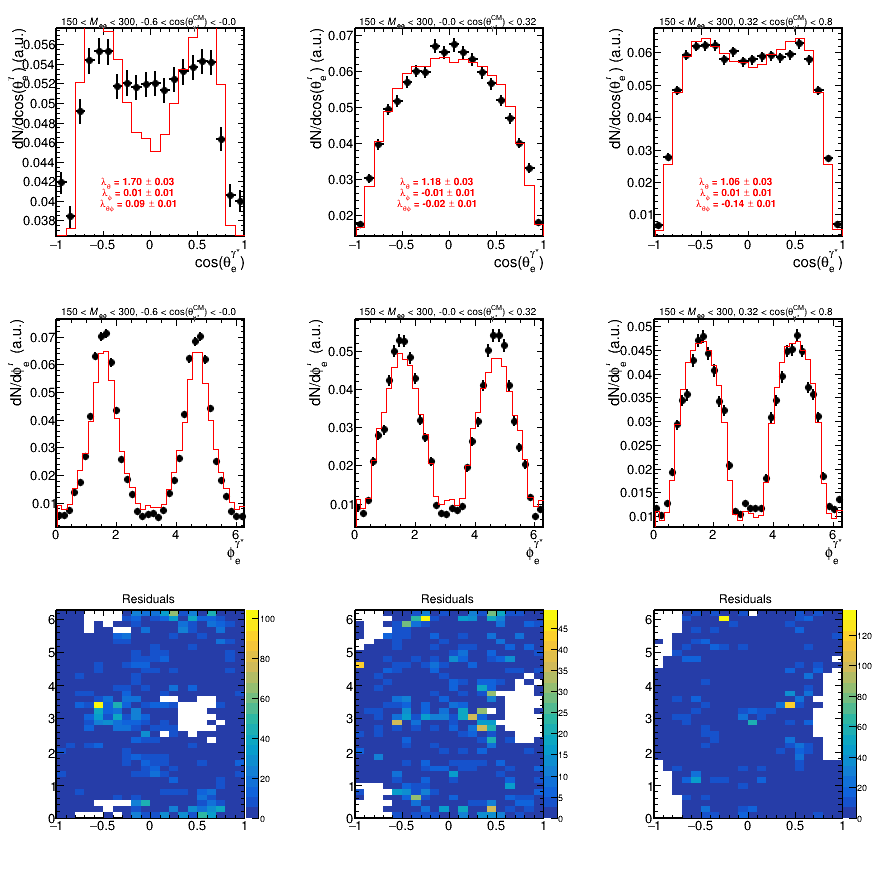

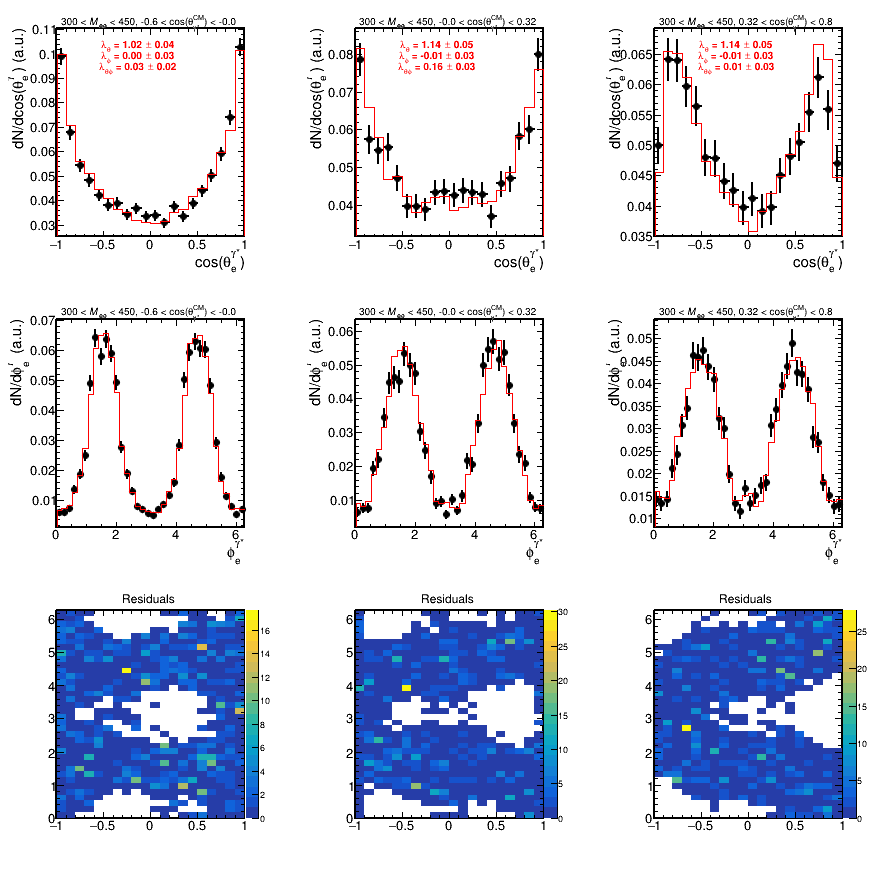

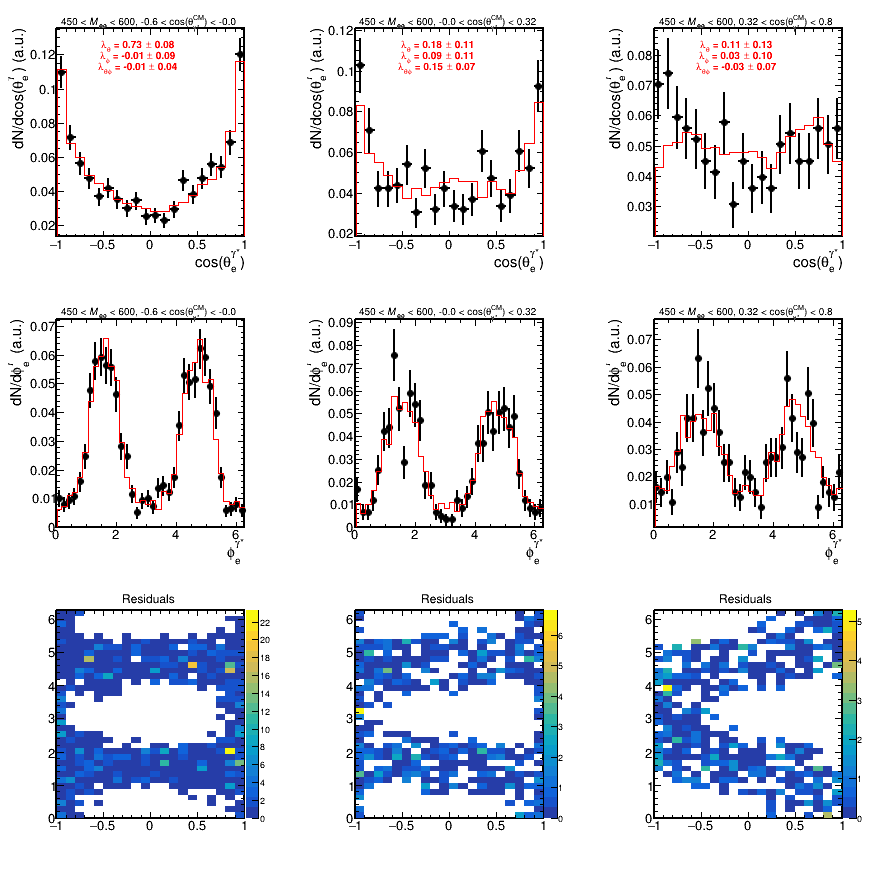

In [14]:
df_nn = show_results("nn", DIR_NAME, range_used, parameters_all_nn, get_hist_maker_mc, bins, histsData_nn, analyse_3d)

In [15]:
if not analyse_3d:
    histsDataCorrs = []
    histsDatas = []
    histsModels = []
    legends = []
    hmodel_null = histMakerMC_rho_heli0_np.make_hists((0.0))
    hmodel_null_pp = histMakerMC_rho_heli0_pp.make_hists((0.0))
    hmodel_null_nn = histMakerMC_rho_heli0_nn.make_hists((0.0))
    hmodel_null_mix = histMakerMC_mix.make_hists((0.0))
    hmodel_null_pi0 = histMakerMC_pi0.make_hists((0.0))
    hmodel_null_heli1 = histMakerMC_rho_heli1.make_hists((0.0))

    pol2s = []
    histsAvg = []
    kfactors = []

    cc4 = TCanvas("cc4","cc4",900,1200)
    cc4.Divide(3,4)
    cc4.Draw()

    cck = TCanvas("cck","cck",900,1200)
    cck.Divide(3,4)

    csig = TCanvas("csig","csig",900,1200)
    csig.Divide(3,4)

    cacc = TCanvas("cacc","cacc",900,1200)
    cacc.Divide(3,4)

    for i, hist_np in enumerate(histsData_np[0]):
    
        if not isinstance(hist_np, list):

            hist_pp = histsData_pp[0][i]
            hist_nn = histsData_nn[0][i]
        
            if symmetrize_explicit:
                symmetrize(hist_np)
                symmetrize(hist_pp)
                symmetrize(hist_nn)
        
            histAvg = geom_avg1d(hist_pp, hist_nn, 0.2)
            histsAvg.append(histAvg)

        
            histCorr_np = hist_np.Clone(hist_np.GetName() + "_corr")
            histCorr_pp = hist_pp.Clone(hist_pp.GetName() + "_corr")
            histCorr_nn = hist_nn.Clone(hist_nn.GetName() + "_corr")
            histsDataCorrs.append(histCorr_np)
            histsDataCorrs.append(histCorr_pp)
            histsDataCorrs.append(histCorr_nn)
            histCorr_np.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        
            pad = cc4.cd(i+1)
            set_pad(pad)       
       
            hist_kfactor = histsData_np_mix[0][i]
            hist_pp_mix = histsData_pp_mix[0][i]
            hist_nn_mix = histsData_nn_mix[0][i]

            if symmetrize_explicit:
                symmetrize(hist_kfactor)
                symmetrize(hist_pp_mix)
                symmetrize(hist_nn_mix)

            histAvg_mix = geom_avg1d(hist_pp_mix, hist_nn_mix, 0.2)
            hist_kfactor.Divide(histAvg_mix)
            hist_kfactor.Scale(2)
            kfactors.append(hist_kfactor)

            pad = cck.cd(i+1)
            set_pad(pad)

            hist_kfactor.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        
            set_th1(hist_kfactor, histCorr_np.GetXaxis().GetTitle(), "#it{k}-factor", 
                   505, 20, 0.8, 1)
            hist_pp_mix.SetLineColor(2)
            hist_nn_mix.SetLineColor(4)
            hist_pp_mix.SetMarkerColor(2)
            hist_nn_mix.SetMarkerColor(4)
            hist_kfactor.Draw()
            hist_pp_mix.Draw("SAME")
            hist_nn_mix.Draw("SAME")
            hist_kfactor.SetMinimum(0)
             
            pad = cc4.cd(i+1)
            set_pad(pad)       
            
            histAvg_withK = histAvg.Clone(histAvg.GetName() + "_withK")
            histsAvg.append(histAvg_withK)
            histAvg_withK.Multiply(hist_kfactor)
            
            histAvg_withK.SetFillStyle(3004)
            histAvg_withK.SetFillColor(45)
            histAvg_withK.SetLineColor(45)
            histAvg.SetLineColor(6)
            hist_pp.SetLineColor(4)
            hist_nn.SetLineColor(2)
                    
            set_th1(hist_np, histCorr_np.GetXaxis().GetTitle(), f"dN/d{histCorr_np.GetXaxis().GetTitle()} (a.u.)", 
                   505, 20, 0.8, 1)
            hist_np.SetMinimum(0)
            hist_np.Draw()
            histAvg_withK.Draw("SAMEHIST")
            histAvg.Draw("SAMEHIST")
            hist_pp.Draw("SAMEHIST")
            hist_nn.Draw("SAMEHIST")
            
            pad = csig.cd(i+1)
            set_pad(pad)     
    
            hist_model_np = hmodel_null_mix[0][i]
            # TODO: make it consistent if we go the way of using mixing
            hist_model_pp = hmodel_null_mix[0][i]
            hist_model_nn = hmodel_null_mix[0][i]
            if not event_mixing:
                if i < 3:
                    hist_model_np = hmodel_null_pi0[0][i]
                    # TODO: make is consisnt if combinatorial background really matters for the pi0 region
                    hist_model_pp = hmodel_null_pi0[0][i]
                    hist_model_nn = hmodel_null_pi0[0][i]
                else:
                    hist_model_np = hmodel_null[0][i]
                    hist_model_pp = hmodel_null_pp[0][i]
                    hist_model_nn = hmodel_null_nn[0][i]
            if symmetrize_explicit:
                symmetrize(hist_model_np)
    
           # histCorr_np.Add(histAvg_withK,-1)
            histCorr_np.Divide(hist_model_np)
            histCorr_pp.Divide(hist_model_pp)
            histCorr_nn.Divide(hist_model_nn)
            
            histAvgCorr = geom_avg1d(histCorr_pp, histCorr_nn, 0.2)
            histsAvg.append(histAvgCorr)
            histAvgCorr_withK = histAvgCorr.Clone(histAvgCorr.GetName() + "_withK")
            histsAvg.append(histAvgCorr_withK)
            histAvgCorr_withK.Multiply(hist_kfactor)
        
            s2b = (hist_np.Integral() - histAvg_withK.Integral()) / histAvg_withK.Integral()
            s2b_corr = (histCorr_np.Integral() - histAvgCorr_withK.Integral()) / histAvgCorr_withK.Integral()
            histCorr_pp.Scale(s2b/s2b_corr)
            histCorr_nn.Scale(s2b/s2b_corr)
            histAvgCorr.Scale(s2b/s2b_corr)
            histAvgCorr_withK.Scale(s2b/s2b_corr)
        
            histAvgCorr_withK.SetFillStyle(3004)
            histAvgCorr_withK.SetFillColor(45)
            histAvgCorr_withK.SetLineColor(45)
            histAvgCorr.SetLineColor(6)
    
            #if symmetrize_explicit:    
                #symmetrize(histCorr_np)
    
            fit = TF1(f"fit_{i}", "[0]*(1+[1]*x*x)",-1.0,1.0)
            fit.SetParameters(1, 1)
            
            histCorr_np.Fit(fit,"Q")
            pol2s.append(fit)
        
            set_th1(histCorr_np, histCorr_np.GetXaxis().GetTitle(), f"dN/d{histCorr_np.GetXaxis().GetTitle()} (a.u.)", 
                   505, 20, 0.8, 1)
        
            histCorr_pp.SetLineColor(4)
            histCorr_nn.SetLineColor(2)
            histCorr_np.Draw()
            histCorr_pp.Draw("SAMEHIST")
            histCorr_nn.Draw("SAMEHIST")
            histAvgCorr.Draw("SAMEHIST")
            histAvgCorr_withK.Draw("SAMEHIST")
            if i < 3:
                # histCorr_np.GetYaxis().SetRangeUser(0,2.5)
                histCorr_np.GetYaxis().SetRangeUser(0,20)
            else:
                # histCorr_np.GetYaxis().SetRangeUser(0,1.25)    
                histCorr_np.GetYaxis().SetRangeUser(0,2)    
            histCorr_np.SetMinimum(0)
            
            caption = f"#lambda_{{#theta}} = {fit.GetParameter(1):.2f} #pm {fit.GetParError(1):.2f}"
            paveText = set_opt_text(caption, 0.25,0.76,0.675,0.88, 2, 0.04)
            paveTexts.append(paveText)
    
            if i == 4:
                l = TLegend(0.3,0.45,0.8,0.8)
                l.SetBorderSize(0)
                l.AddEntry(histCorr_np,"e+e- pairs","pl")
                l.AddEntry(histCorr_pp,"e+e+ pairs","l")
                l.AddEntry(histCorr_nn,"e-e- pairs","l")
                l.AddEntry(histAvgCorr,"geom. mena","pl")
                l.AddEntry(histAvgCorr_withK,"geom. mena with k-factor","pl")
                l.Draw()
                legends.append(l)
            
    
            pad = cacc.cd(i+1)
            set_pad(pad)
            
            hacc_heli0 = hmodel_null[0][i]
            hacc_heli1 = hmodel_null_heli1[0][i]
    
        else:
            print(hist_np)
    
    cc4.SaveAs(f"{DIR_NAME}/fit_classic.gif")
    cc4.SaveAs(f"{DIR_NAME}/fit_classic.pdf")
        


In [16]:
if not analyse_3d:
    cck.Draw()
    cck.SaveAs(f"{DIR_NAME}/kfactor.gif")
    
    csig.Draw()
    csig.SaveAs(f"{DIR_NAME}/signal.gif")
    csig.SaveAs(f"{DIR_NAME}/signal.eps")


Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/can_mass_z_np.gif has been created


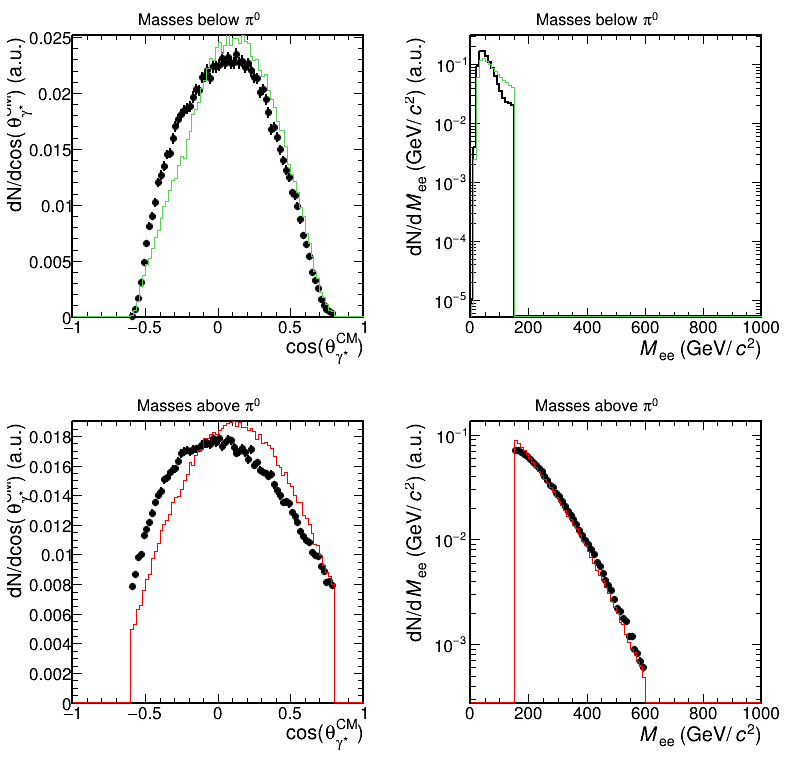

In [17]:
can_mass_z_np = show_mass_z(histsData_np, histMakerMC_pi0, histMakerMC_rho_heli0_np, histMakerMC_mix, event_mixing, fraction, DIR_NAME, "np")

Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/can_mass_z_pp.gif has been created


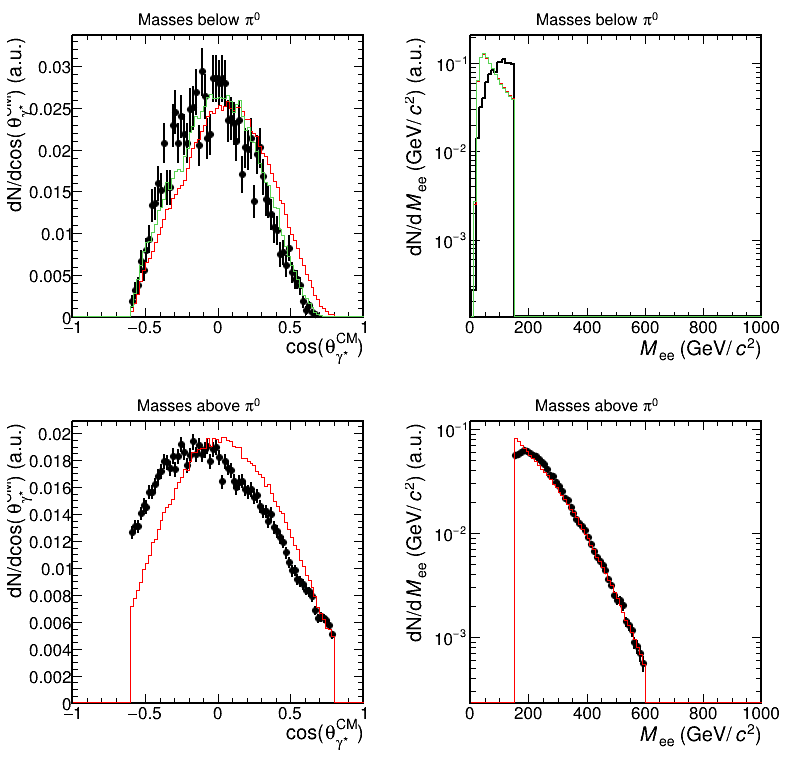

In [18]:
can_mass_z_pp = show_mass_z(histsData_pp, histMakerMC_pi0, histMakerMC_rho_heli0_pp, histMakerMC_mix, event_mixing, fraction, DIR_NAME, "pp")

Info in <TCanvas::Print>: gif file results_ag1580ag_3d_nosymm_HX/can_mass_z_nn.gif has been created


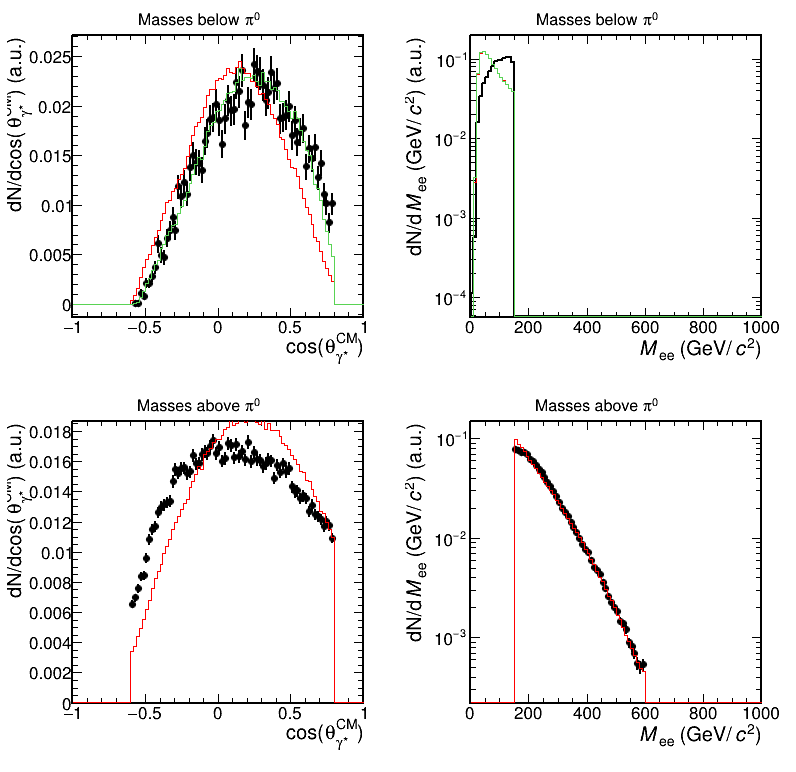

In [19]:
can_mass_z_np = show_mass_z(histsData_nn, histMakerMC_pi0, histMakerMC_rho_heli0_nn, histMakerMC_mix, event_mixing, fraction, DIR_NAME, "nn")

In [20]:
if not analyse_3d:
    cacc.Draw()
    cacc.SaveAs(f"{DIR_NAME}/cacc.gif")

In [21]:
import math
import pandas as pd

a_np = df_np['yield']/(math.pi * (df_np['lambda_theta'] + 3)) * (3./4)
a_pp = df_pp['yield']/(math.pi * (df_pp['lambda_theta'] + 3)) * (3./4)
a_nn = df_nn['yield']/(math.pi * (df_nn['lambda_theta'] + 3)) * (3./4)

yield_sig = df_np['yield'] - df_pp['yield'] - df_nn['yield'] 

term_np = (4./15) * a_np * math.pi * (5 + 3*df_np['lambda_theta'])
term_pp = (4./15) * a_pp * math.pi * (5 + 3*df_pp['lambda_theta'])
term_nn = (4./15) * a_nn * math.pi * (5 + 3*df_nn['lambda_theta'])

term_x = term_np - 1.0*(term_pp + term_nn)
lambda_theta_sig = (3 * term_x - 5 * yield_sig) / (3 * yield_sig - term_x)

a_sig = yield_sig/(math.pi * (lambda_theta_sig + 3)) * (3./4)

lambda_phi_sig = (a_np * df_np['lambda_phi'] - a_pp * df_pp['lambda_phi'] - a_nn * df_nn['lambda_phi']) / a_sig
lambda_theta_phi_sig = (a_np * df_np['lambda_theta_phi'] - a_pp * df_pp['lambda_theta_phi'] - a_nn * df_nn['lambda_theta_phi']) / a_sig

df_result = pd.DataFrame(columns=['a_np', 'a_pp', 'a_nn', 'yield_sig', 'term_np', 'term_pp', 'term_nn', 'term_x', 'a_sig', 'lambda_theta_sig', 'lambda_phi_sig', 'lambda_theta_phi_sig'])
df_result['a_np'] = a_np
df_result['a_pp'] = a_pp
df_result['a_nn'] = a_nn
df_result['term_np'] = term_np
df_result['term_pp'] = term_pp
df_result['term_nn'] = term_nn
df_result['term_x'] = term_x
df_result['yield_sig'] = yield_sig
df_result['a_sig'] = a_sig
df_result['lambda_theta_sig'] = lambda_theta_sig
df_result['lambda_phi_sig'] = lambda_phi_sig
df_result['lambda_theta_phi_sig'] = lambda_theta_phi_sig

df_result

,a_np,a_pp,a_nn,yield_sig,term_np,term_pp,term_nn,term_x,a_sig,lambda_theta_sig,lambda_phi_sig,lambda_theta_phi_sig
0,2942.524724,182.443321,56.084841,36868.0,14889.505006,595.826562,1234.057893,13059.620551,5821.751310,-1.488155,0.006179,0.015130
1,2320.998476,65.728246,134.091321,30082.0,12820.859454,563.942533,1315.855670,10941.061252,4733.164880,-1.482717,-0.011711,-0.051930
2,1466.850997,20.081327,213.617512,16828.0,7561.535129,188.906828,1408.160847,5964.467453,2657.063876,-1.488034,-0.006655,-0.070286
3,5508.991006,1612.931979,1710.737102,32477.0,36719.393947,10098.413061,14457.864947,12163.115939,5089.051963,-1.476472,0.006482,-0.006240
4,3470.558837,602.810591,1341.699689,21888.0,23573.845712,5971.362320,9583.521187,8018.962205,3440.434766,-1.481188,0.004845,0.022090
5,3688.780599,603.250277,1764.221313,19352.0,23852.977568,4585.088918,12084.437635,7183.451015,3036.231614,-1.478394,-0.007271,0.094176
6,1701.196887,426.540061,503.149105,10578.0,9998.834515,2841.450536,3395.931165,3761.452815,1669.488433,-1.487374,0.009860,0.025326
7,921.057243,186.912976,255.121736,6227.0,5330.307554,1401.048606,1798.278858,2130.980090,987.756554,-1.494987,-0.042070,-0.053001
8,1047.876139,198.213194,313.729574,7176.0,6223.533355,1501.181212,2212.682106,2509.670037,1135.072959,-1.490719,-0.015235,0.020035
9,319.025249,73.302527,88.420081,2192.0,1755.136129,433.560875,533.501465,788.073789,345.441400,-1.485122,0.014664,0.022553
